In [1]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>


In [5]:
twitter_df =pd.read_csv('Tweets.csv')
twitter_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
twitter_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
twitter_df.shape

(14640, 15)

In [8]:
twitter_df.isnull().sum()


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
twitter_df.duplicated().sum()

36

In [10]:
# Unique values of sentiment
twitter_df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [11]:
twitter_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [12]:
twitter_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


array([[<AxesSubplot:title={'center':'tweet_id'}>,
        <AxesSubplot:title={'center':'airline_sentiment_confidence'}>],
       [<AxesSubplot:title={'center':'negativereason_confidence'}>,
        <AxesSubplot:title={'center':'retweet_count'}>]], dtype=object)

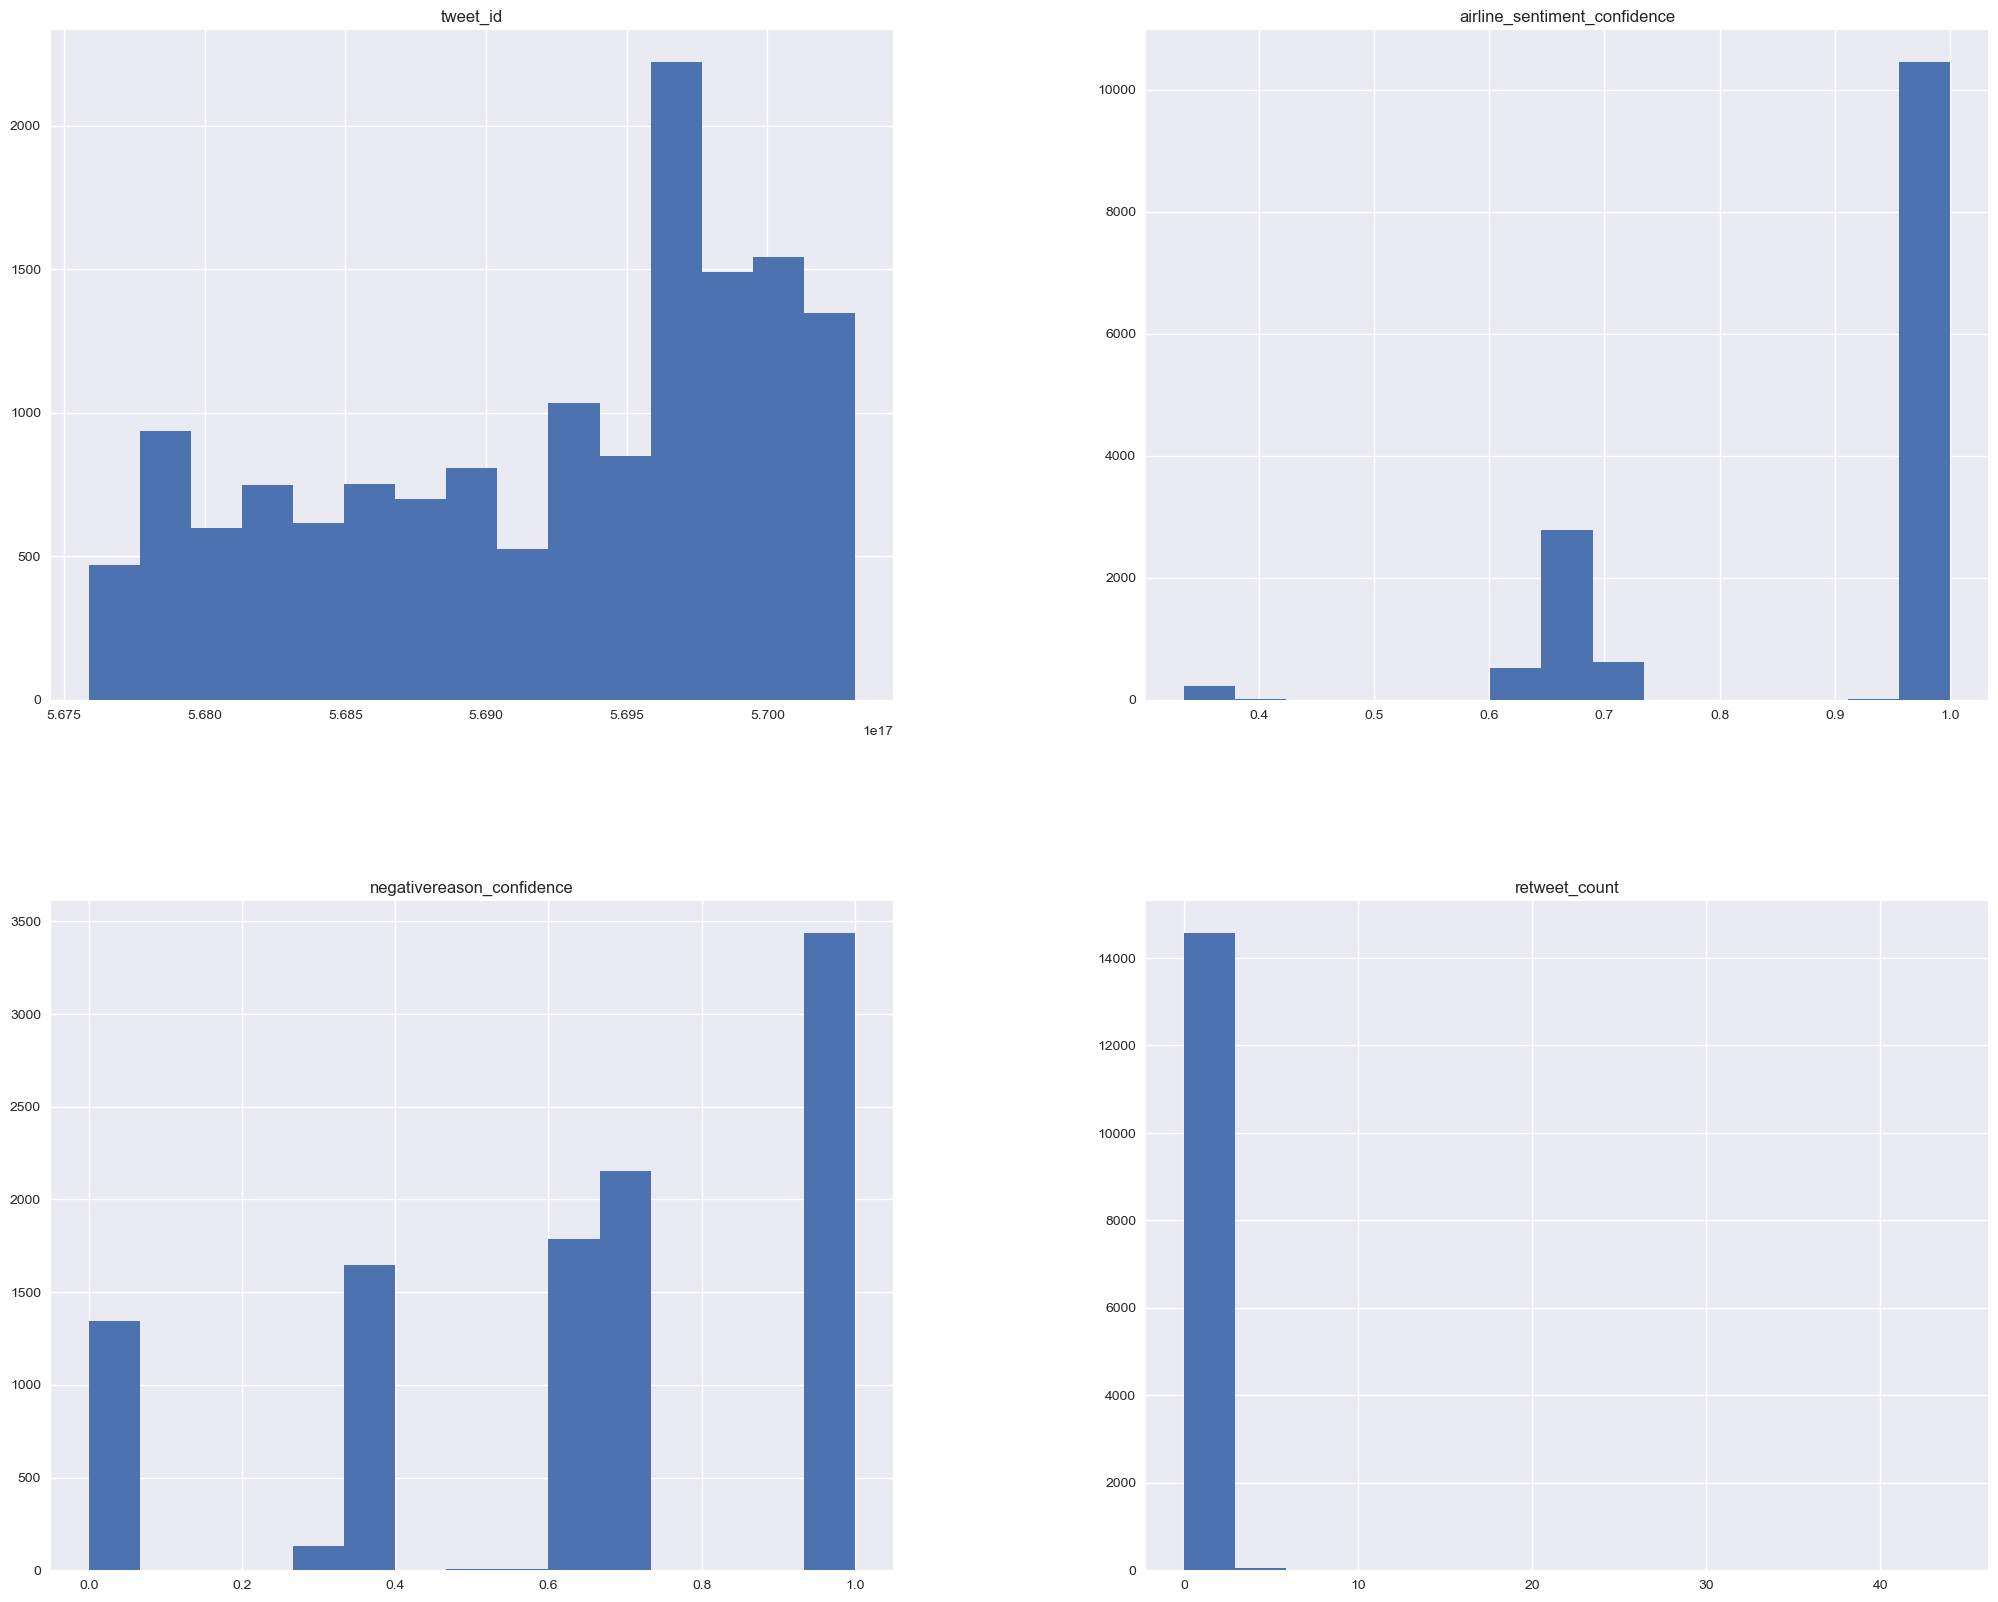

In [13]:
plt.style.use("seaborn")
twitter_df.hist(figsize=(25,20), bins=15)

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

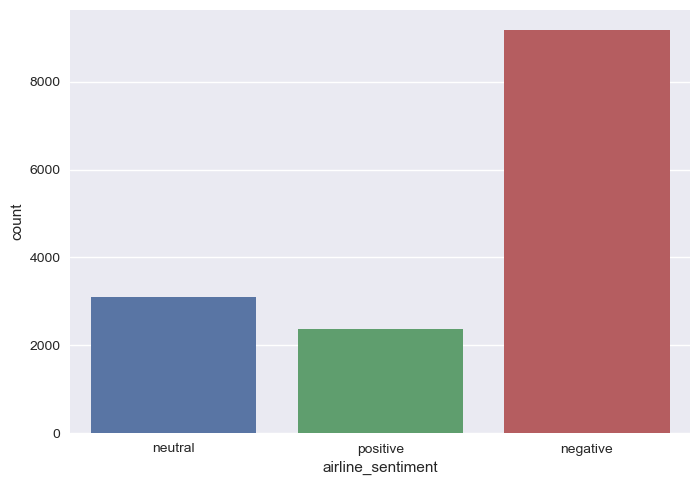

In [14]:
sns.countplot(x="airline_sentiment", data=twitter_df)

<AxesSubplot:xlabel='airline', ylabel='count'>

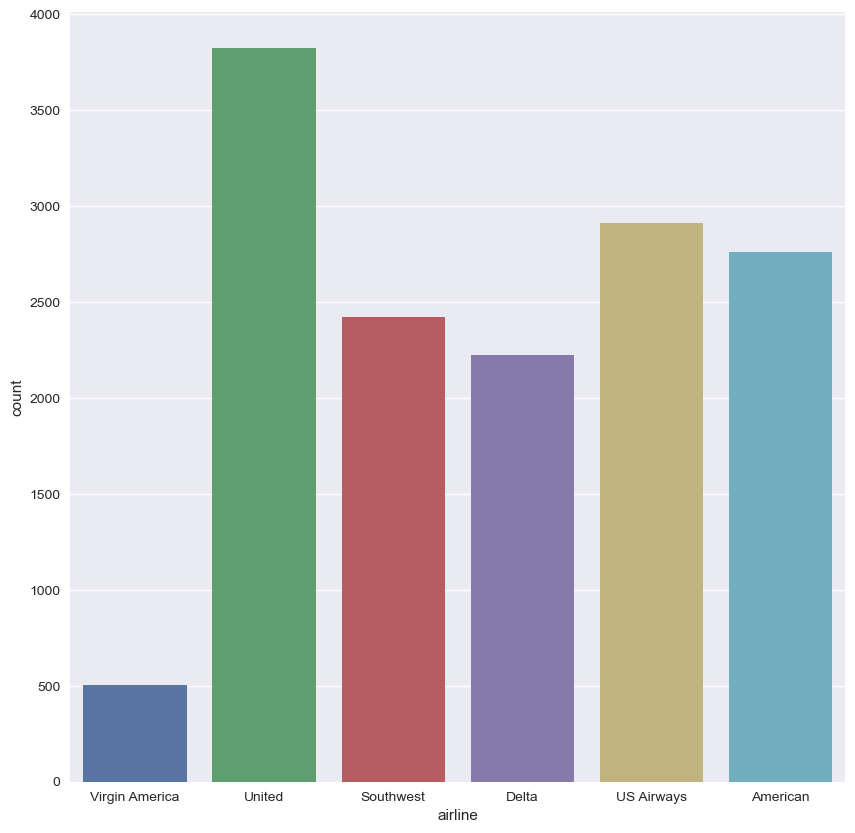

In [15]:
plt.figure(figsize=(10,10))
sns.countplot(x="airline", data=twitter_df)

<AxesSubplot:xlabel='retweet_count', ylabel='count'>

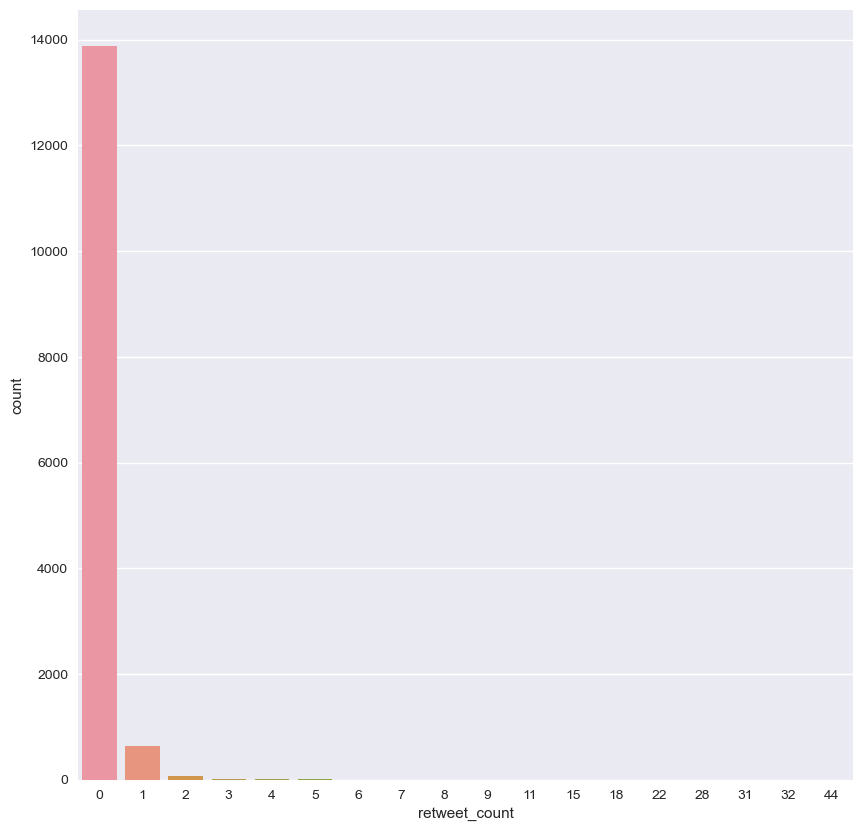

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x="retweet_count", data=twitter_df)

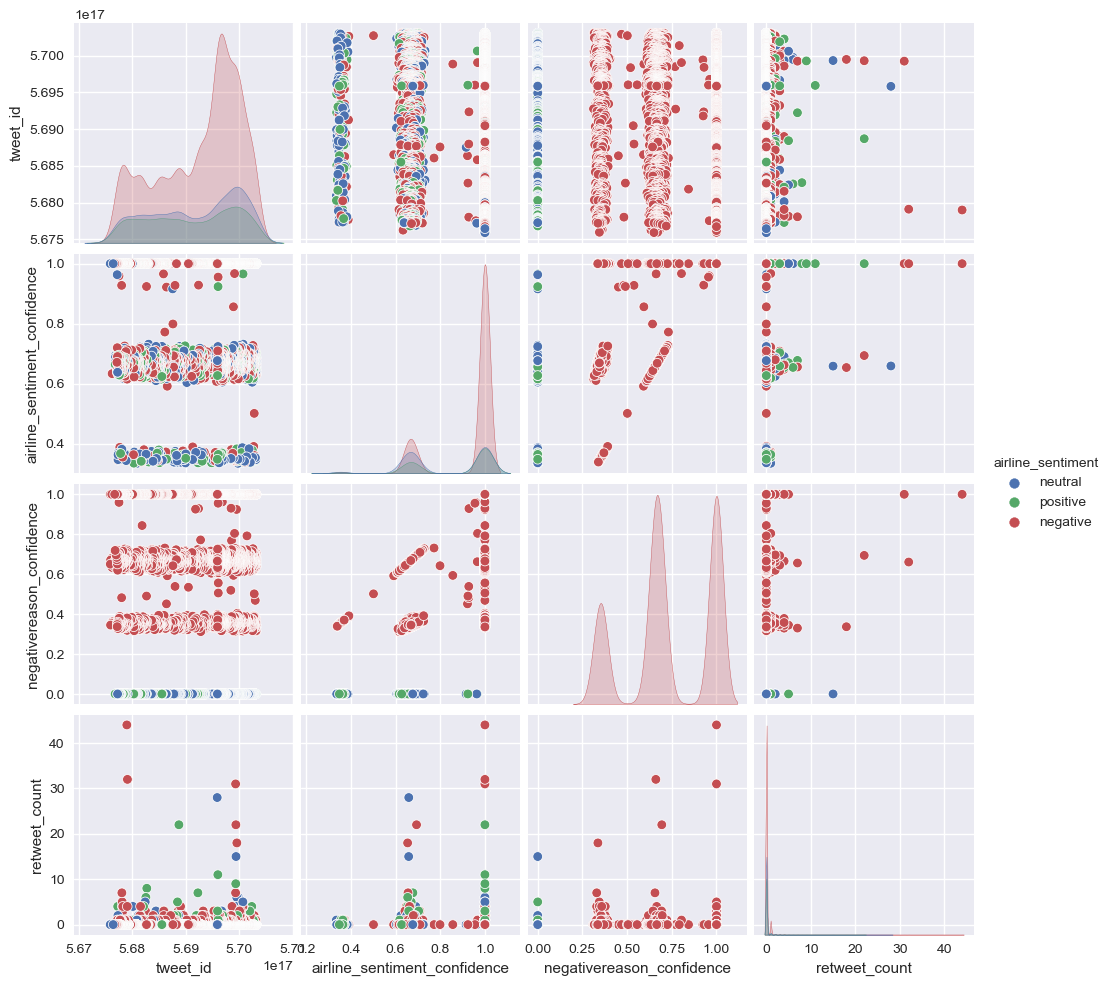

In [17]:
sns.pairplot(twitter_df,hue='airline_sentiment')

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


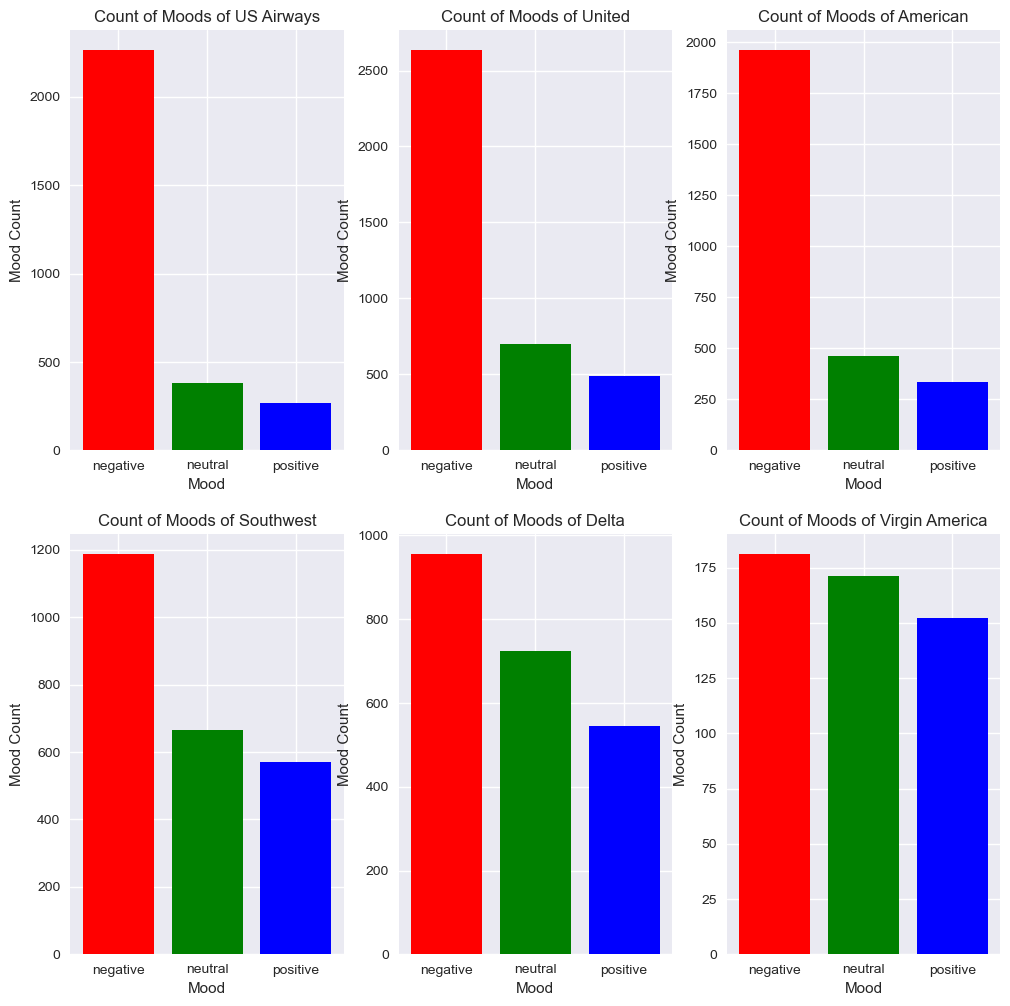

In [18]:
print("Total number of tweets for each airline \n ",twitter_df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=twitter_df[twitter_df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)


            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


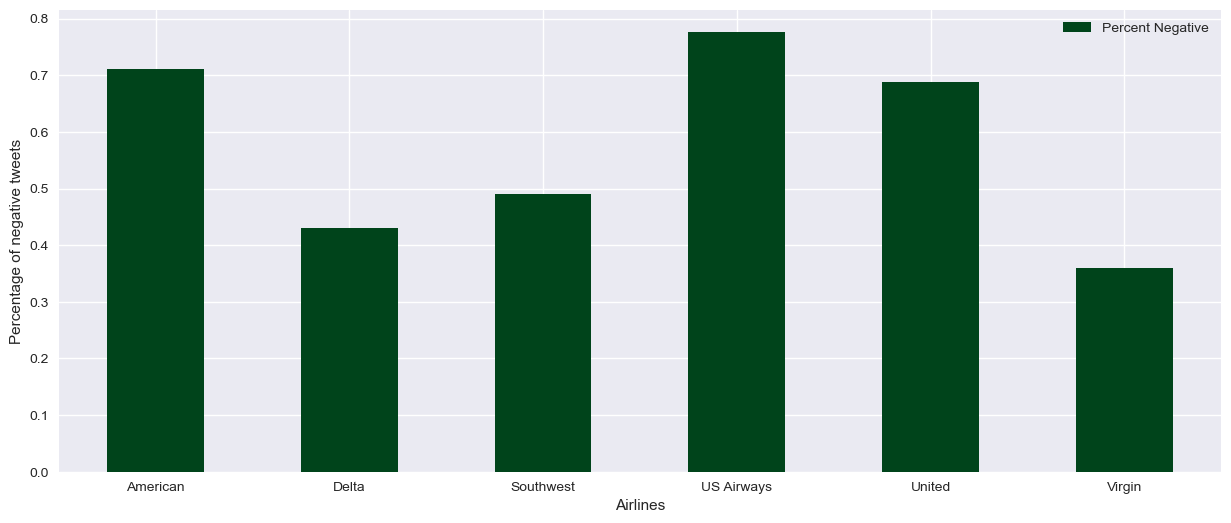

In [19]:
neg_tweets = twitter_df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = twitter_df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

<AxesSubplot:xlabel='airline'>

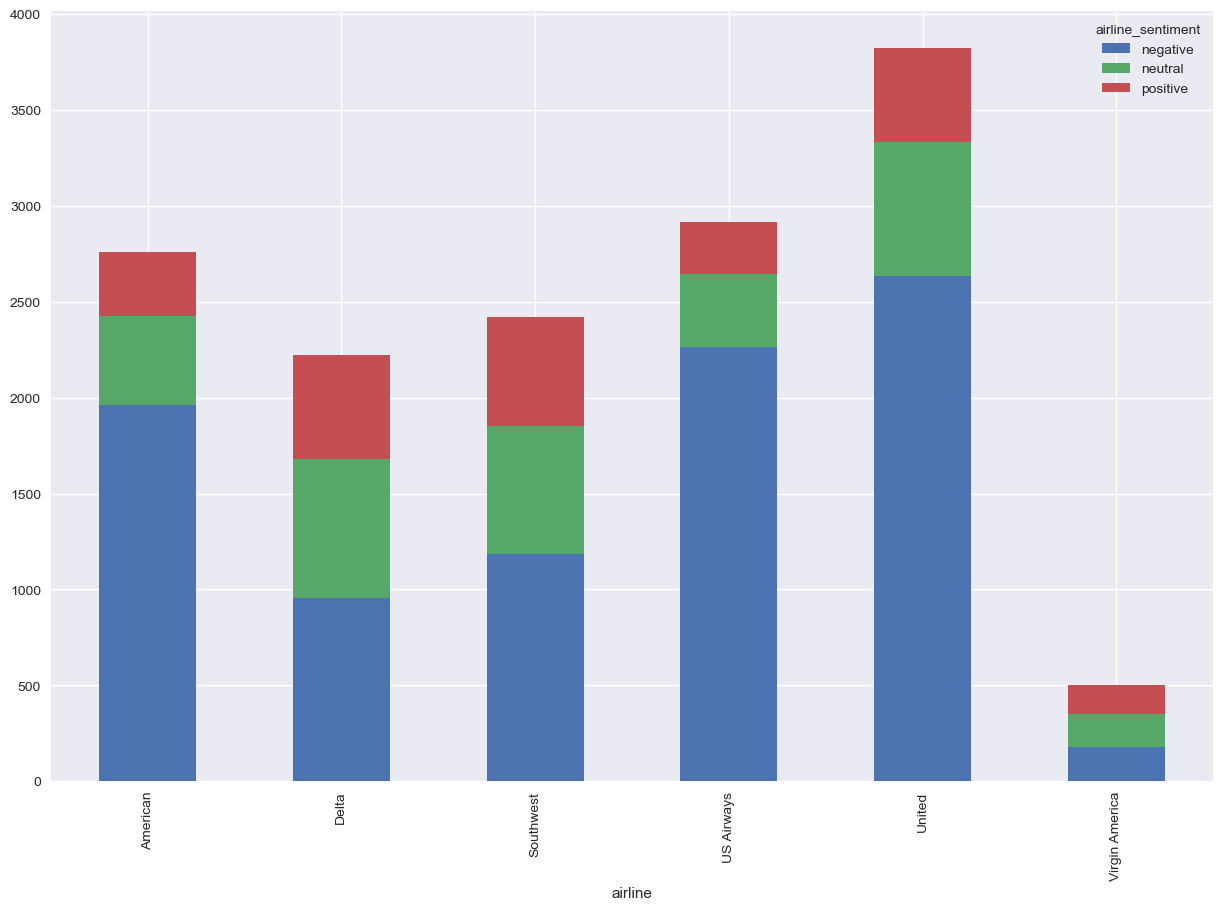

In [20]:
figure_2 = twitter_df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

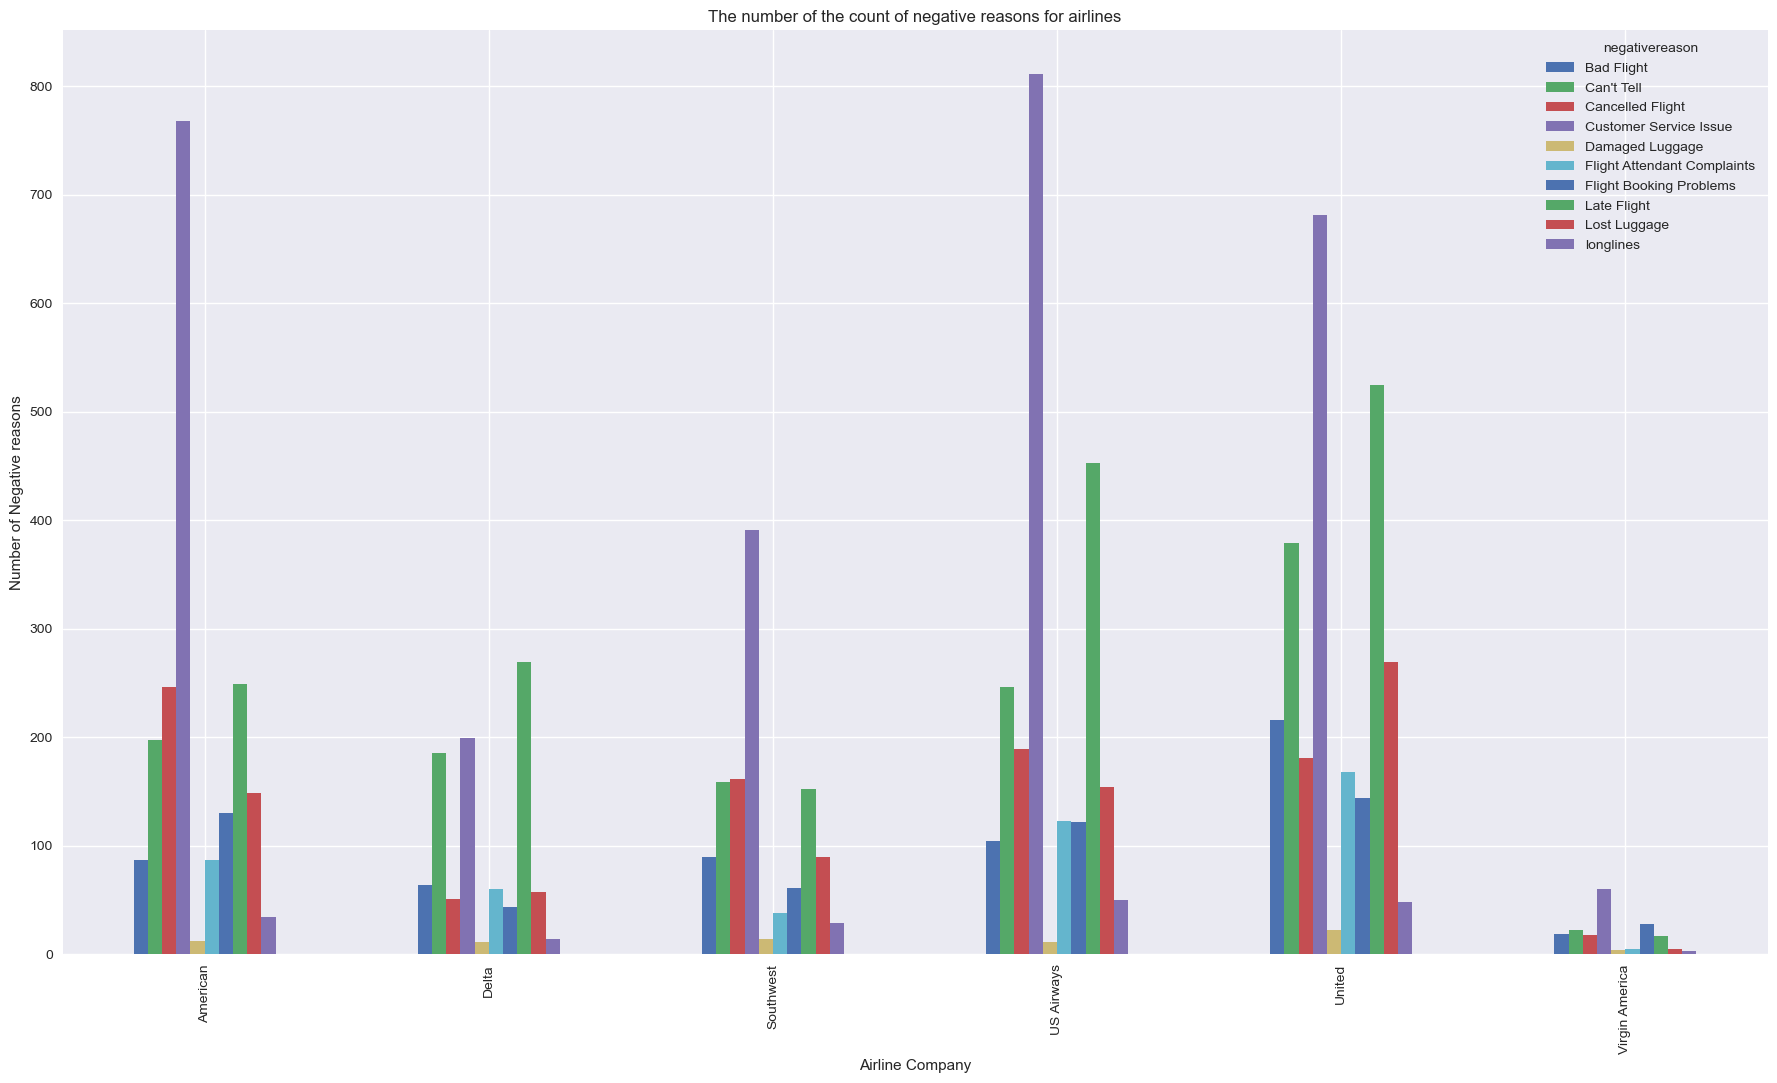

In [21]:
negative_reasons = twitter_df.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(22,12))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

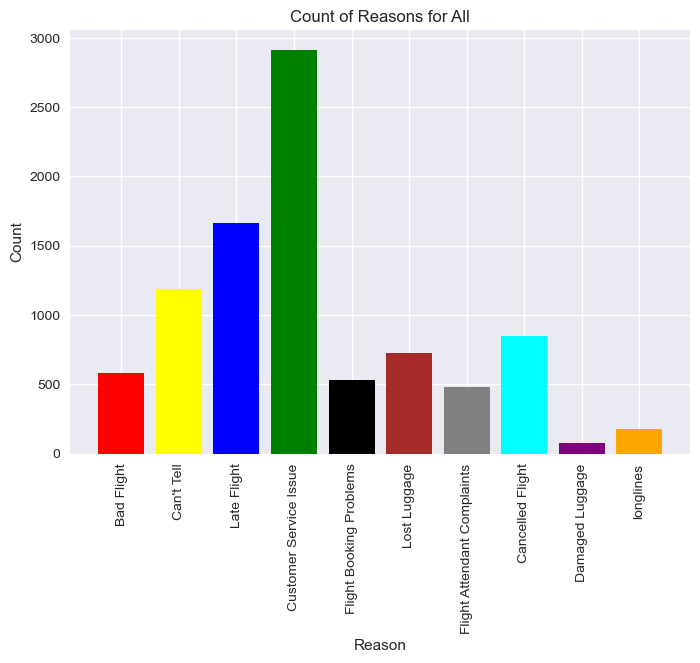

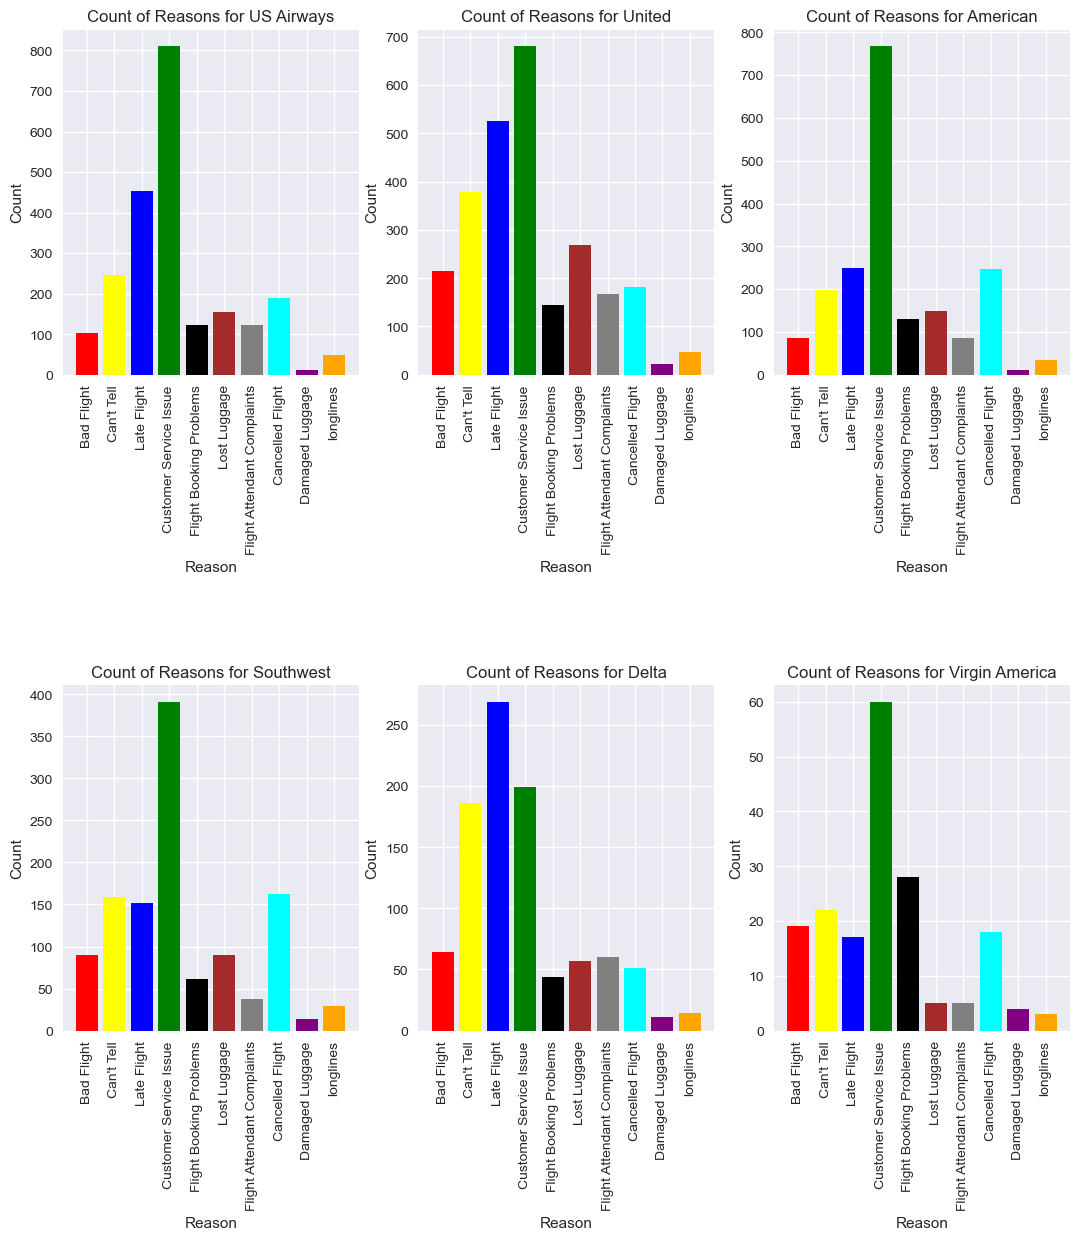

In [22]:
twitter_df['negativereason'].nunique()

NR_Count=dict(twitter_df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=twitter_df
    else:
        a=twitter_df[twitter_df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(twitter_df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
      a=NR_Count(Airline)
      count=a['count']
      Index = range(1,(len(a)+1))
      plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
      plt.xticks(Index,a['Reasons'],rotation=90)
      plt.ylabel('Count')
      plt.xlabel('Reason')
      plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [23]:
date = twitter_df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

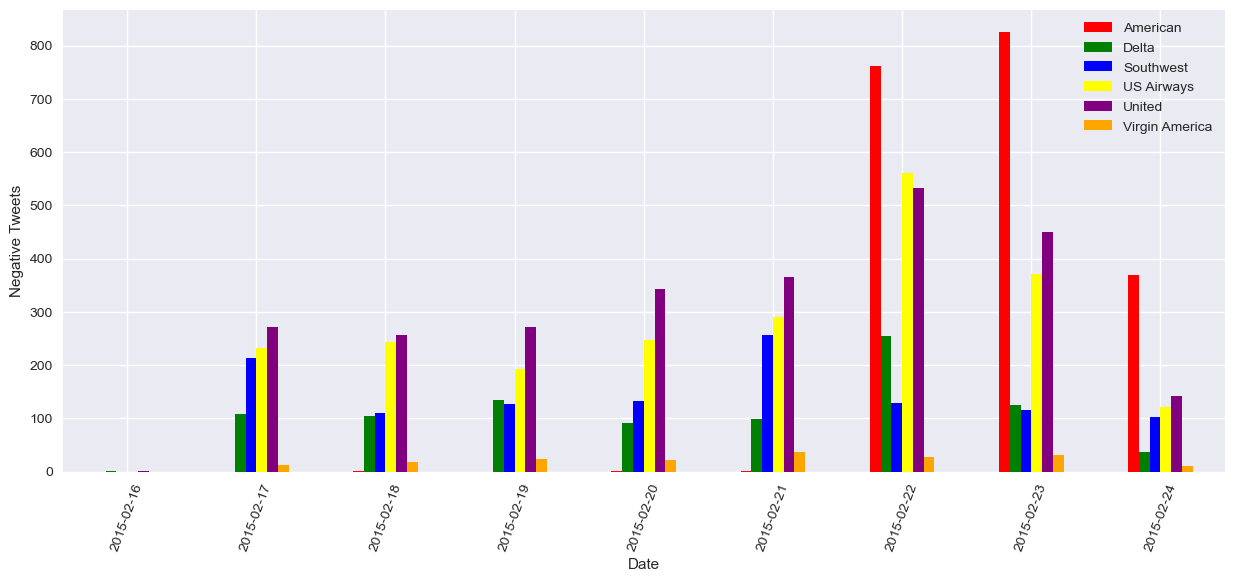

In [24]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

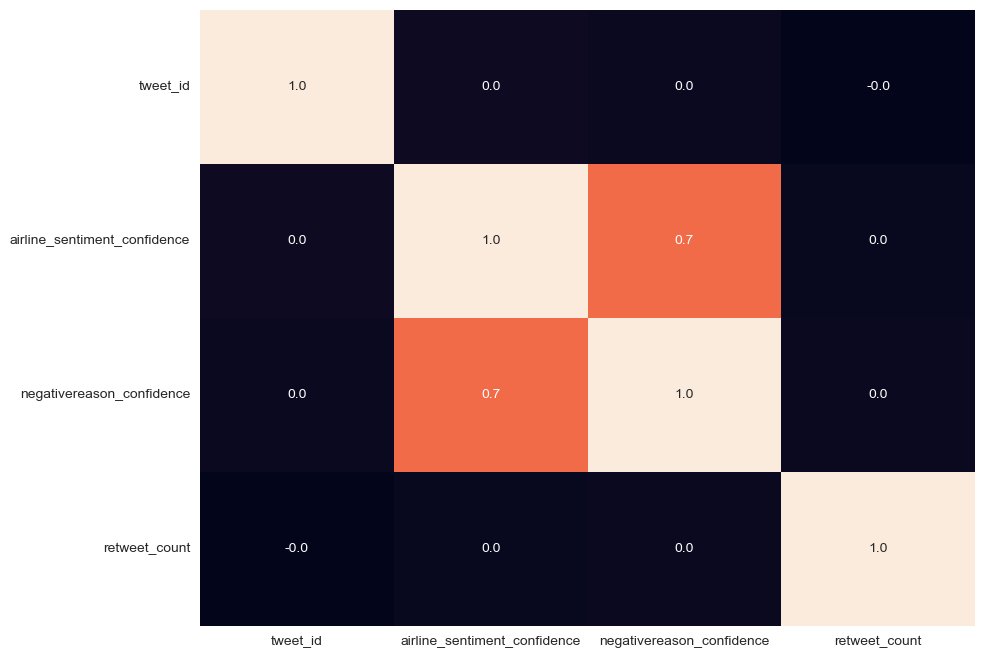

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(twitter_df.corr(),annot=True,cbar=False,fmt='.1f')
plt.show()

Text(0.5, 1.0, 'Features Correlating with airline sentiment confidence')

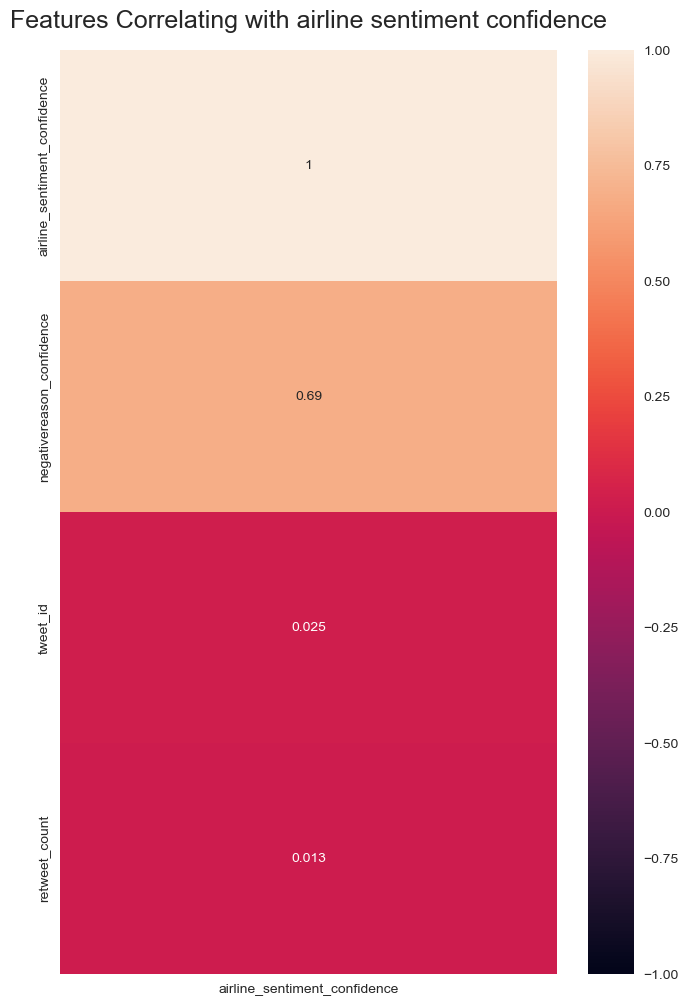

In [26]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(twitter_df.corr()[['airline_sentiment_confidence']].sort_values(by='airline_sentiment_confidence', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with airline sentiment confidence', fontdict={'fontsize':18}, pad=16)

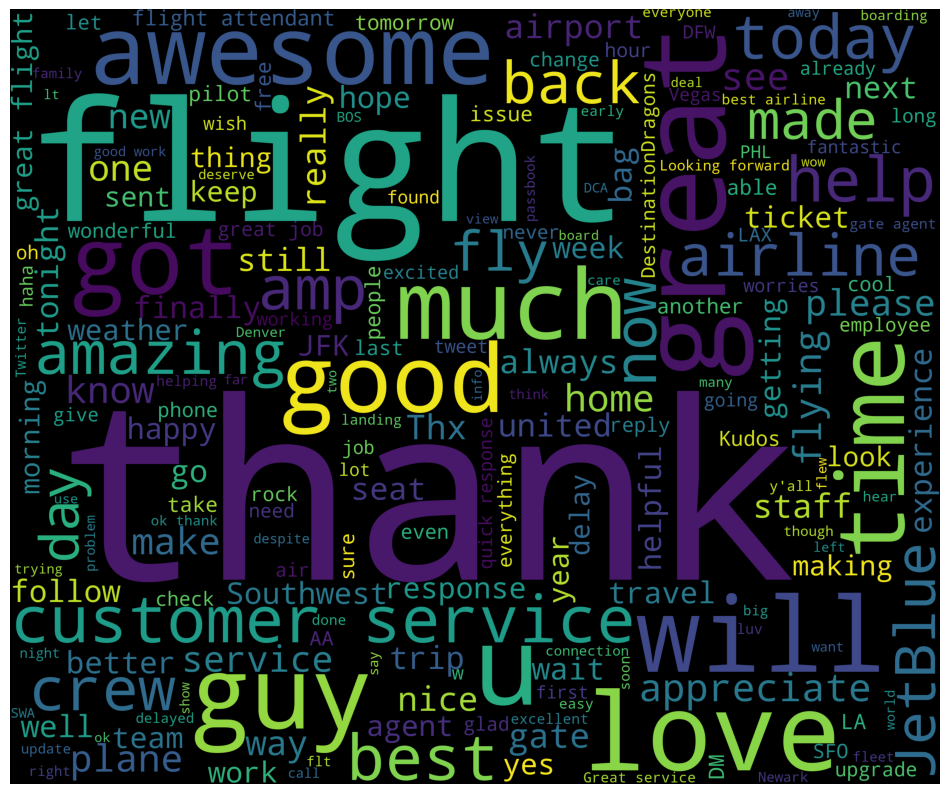

In [27]:
from wordcloud import WordCloud,STOPWORDS
new_df=twitter_df[twitter_df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


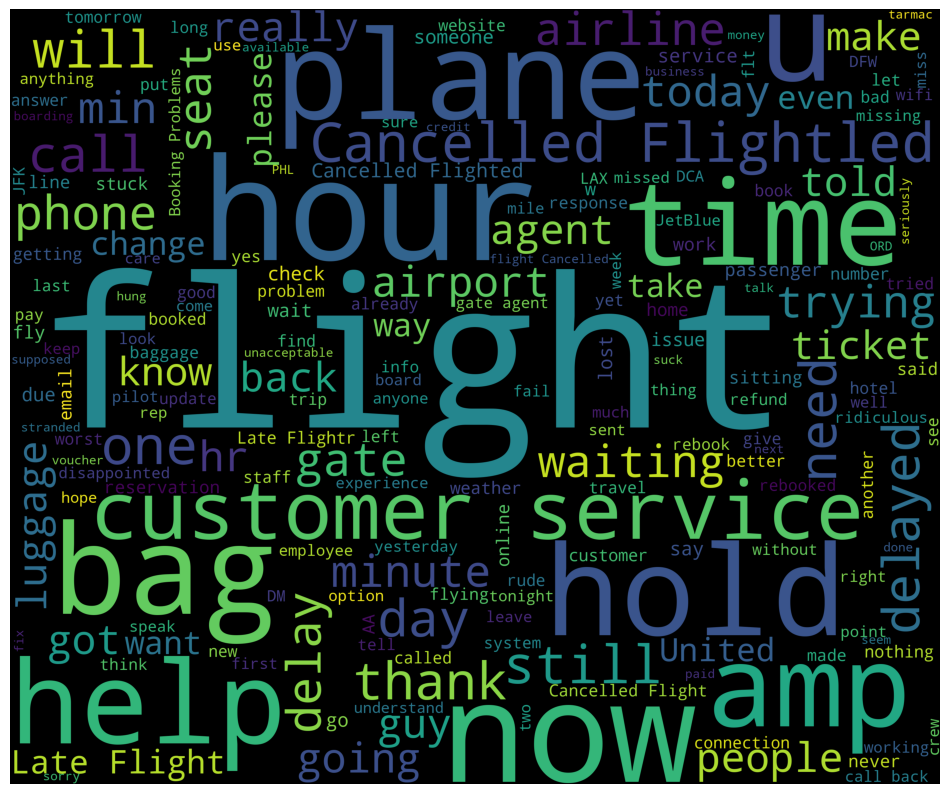

In [28]:
new_df=twitter_df[twitter_df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

 
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)

 
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
    
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

# Text Preparation

In [30]:
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [31]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),really big bad thing
3,5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


In [32]:
df['airline_sentiment'].unique()

array([1, 0], dtype=int64)

# Base SVM model with TF_IDF

In [33]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.9291722515366836

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.8049822712869207


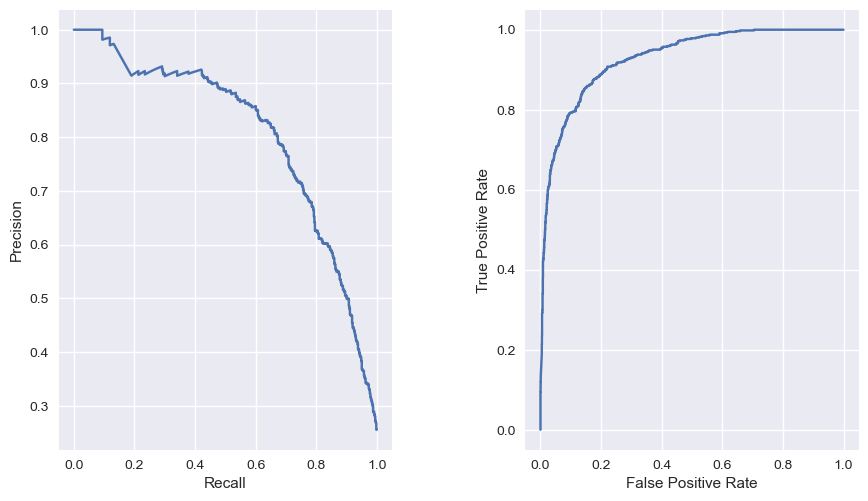

In [34]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

# Optimizing the Hyperparameter with TF-IDF

In [35]:
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}



svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   7.1s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   4.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   4.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   3.2s
[CV] END ..................C=0.1, gamma=auto, ke

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975

Train ROC-AUC score:  0.9987310154793744
Test ROC-AUC score:  0.9287257168067566

Are under Precision-Recall curve: 0.6824034334763949
Area under ROC-AUC: 0.8075481968430164


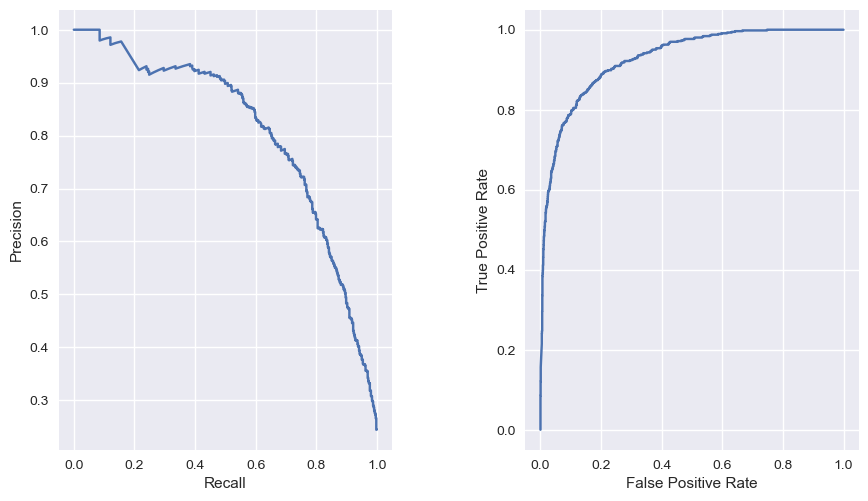

In [36]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

# Multinomial Naive Bayes

Train confusion matrix is: 
[[6853    2]
 [1296  504]]

Test confusion matrix is: 
[[2318    5]
 [ 474   89]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334

Train ROC-AUC score:  0.9561105438041981
Test ROC-AUC score:  0.9013005324009118

Are under Precision-Recall curve: 0.2709284627092846
Area under ROC-AUC: 0.7374839454006489


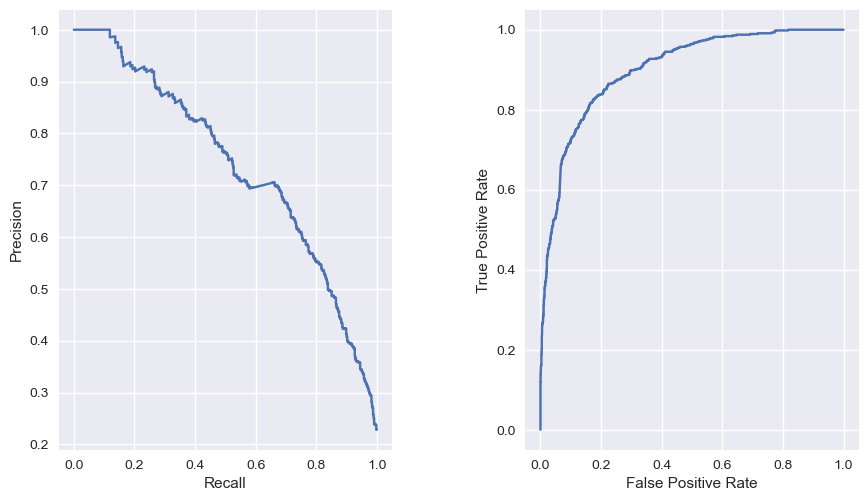

In [37]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

# Gaussian Naive Bayes

Train confusion matrix is: 
[[5543 1312]
 [   0 1800]]

Test confusion matrix is: 
[[1623  700]
 [ 181  382]]

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2323
           1       0.35      0.68      0.46       563

    accuracy                           0.69      2886
   macro avg       0.63      0.69      0.63      2886
weighted avg       0.79      0.69      0.72      2886


Train accuracy score:  0.8484113229347198
Test accuracy score:  0.6947331947331947

Train ROC-AUC score:  0.9043034281546316
Test ROC-AUC score:  0.688586755810495

Are under Precision-Recall curve: 0.4644376899696049
Area under ROC-AUC: 0.5471372315951626


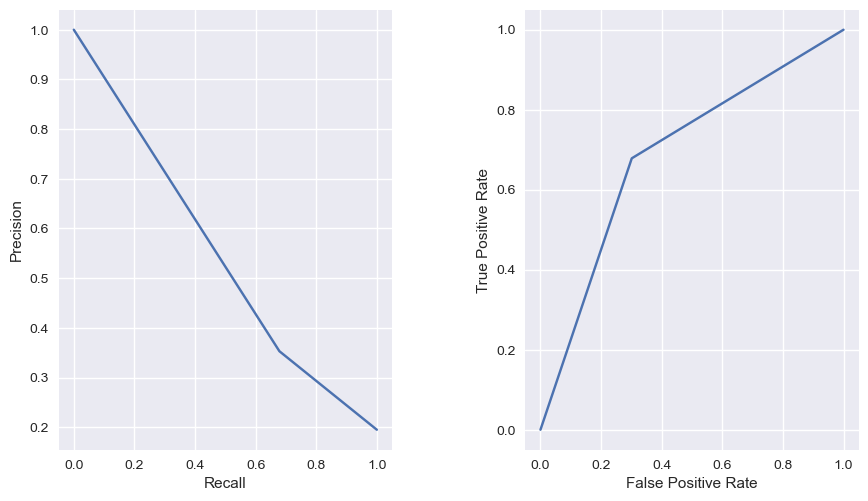

In [38]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)

# AdaBoost

Train confusion matrix is: 
[[6655  200]
 [1012  788]]

Test confusion matrix is: 
[[2251   72]
 [ 328  235]]

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2323
           1       0.77      0.42      0.54       563

    accuracy                           0.86      2886
   macro avg       0.82      0.69      0.73      2886
weighted avg       0.85      0.86      0.84      2886


Train accuracy score:  0.8599653379549393
Test accuracy score:  0.8613998613998614

Train ROC-AUC score:  0.8689482940270687
Test ROC-AUC score:  0.8373803091947158

Are under Precision-Recall curve: 0.5402298850574713
Area under ROC-AUC: 0.6298876361965743


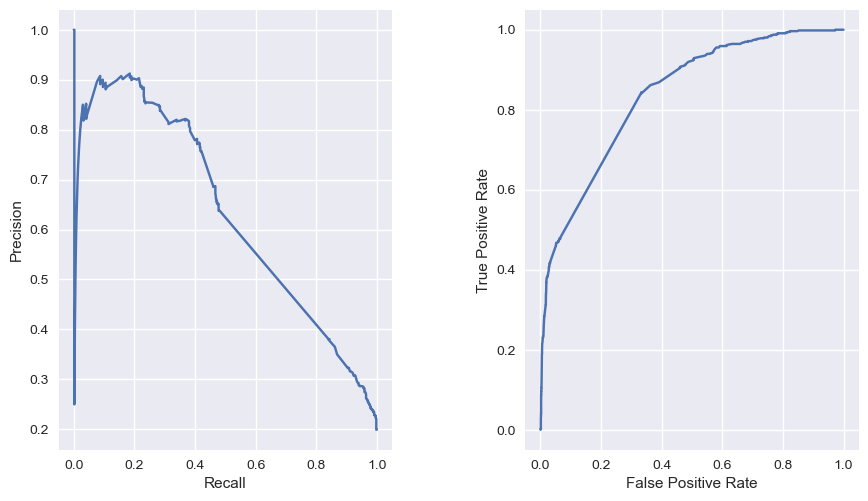

In [39]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)

# AdaBoost With Hyperparameters

In [40]:
params = {'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   1.6s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   1.7s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   3.3s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   3.6s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  17.7s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  17.3s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   1.7s
[CV] END algor

Train confusion matrix is: 
[[6761   94]
 [1043  757]]

Test confusion matrix is: 
[[2278   45]
 [ 340  223]]

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2323
           1       0.83      0.40      0.54       563

    accuracy                           0.87      2886
   macro avg       0.85      0.69      0.73      2886
weighted avg       0.86      0.87      0.85      2886


Train accuracy score:  0.868630849220104
Test accuracy score:  0.8665973665973666

Train ROC-AUC score:  0.9218550936056407
Test ROC-AUC score:  0.8779339205061136

Are under Precision-Recall curve: 0.5367027677496993
Area under ROC-AUC: 0.7021179688268547


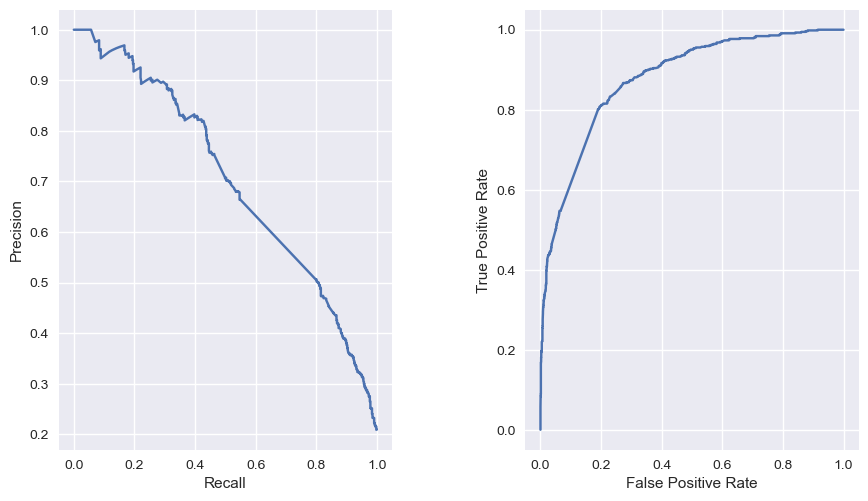

In [41]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)

# KNieghbours

Train confusion matrix is: 
[[1504 5351]
 [  53 1747]]

Test confusion matrix is: 
[[ 190 2133]
 [  31  532]]

              precision    recall  f1-score   support

           0       0.86      0.08      0.15      2323
           1       0.20      0.94      0.33       563

    accuracy                           0.25      2886
   macro avg       0.53      0.51      0.24      2886
weighted avg       0.73      0.25      0.18      2886


Train accuracy score:  0.3756210283073368
Test accuracy score:  0.25017325017325015

Train ROC-AUC score:  0.8180313234459843
Test ROC-AUC score:  0.5533394910268694

Are under Precision-Recall curve: 0.3296158612143742
Area under ROC-AUC: 0.3754013913934616


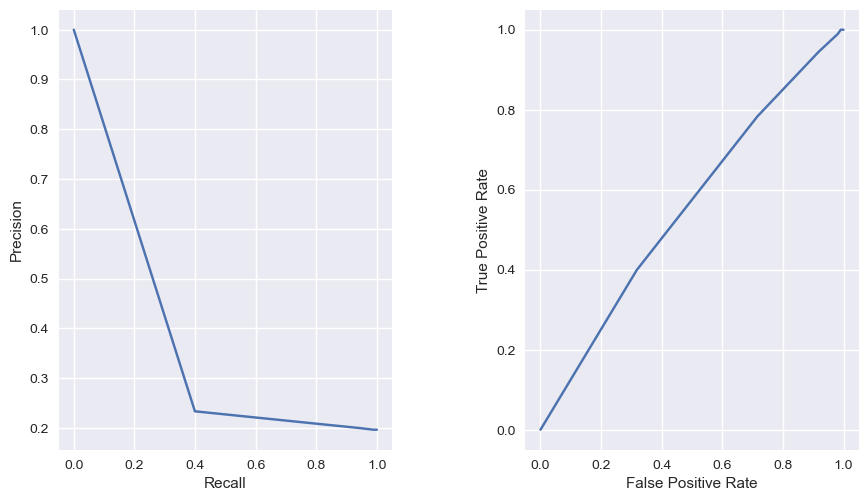

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn_train_accuracy, knn_test_accuracy, knn_train_auc, knn_test_auc= check_scores(KNeighborsClassifier().fit(x_train, y_train), x_train,x_test,y_train,y_test)

# Random Forest

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801

Train ROC-AUC score:  0.9982442661479861
Test ROC-AUC score:  0.8956867344777572

Are under Precision-Recall curve: 0.6526104417670683
Area under ROC-AUC: 0.7441899264879837


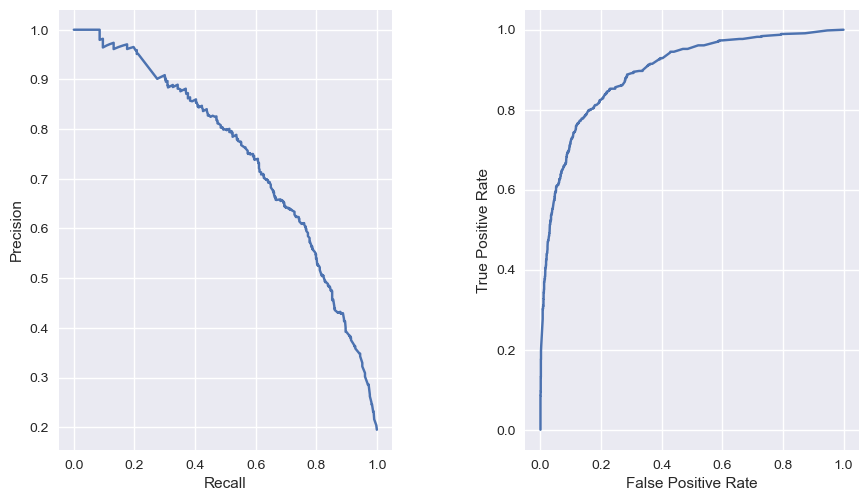

In [43]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

# Decision Tree

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2039  284]
 [ 199  364]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2323
           1       0.56      0.65      0.60       563

    accuracy                           0.83      2886
   macro avg       0.74      0.76      0.75      2886
weighted avg       0.84      0.83      0.84      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8326403326403327

Train ROC-AUC score:  0.9998750303914418
Test ROC-AUC score:  0.7627015809929127

Are under Precision-Recall curve: 0.6011560693641619
Area under ROC-AUC: 0.6116197326239008


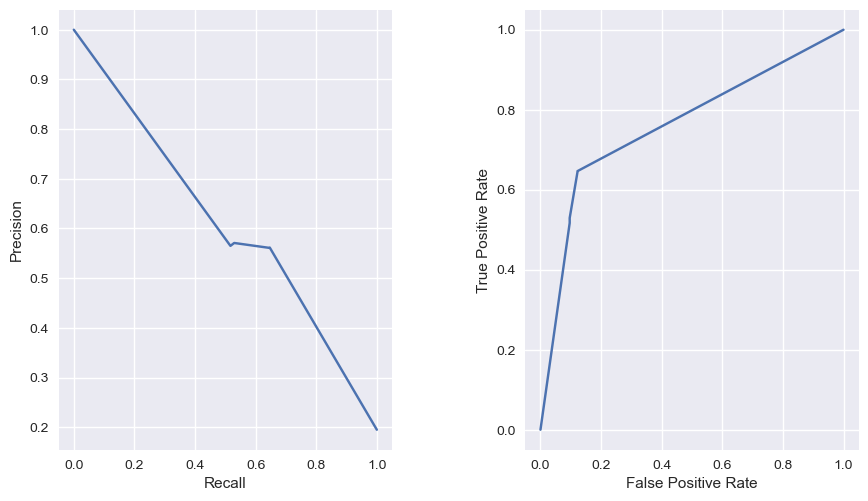

In [44]:
from sklearn.tree import DecisionTreeClassifier
dt_train_accuracy, dt_test_accuracy, dt_train_auc, dt_test_auc= check_scores(DecisionTreeClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

# Neural Network

Train confusion matrix is: 
[[6825   30]
 [   5 1795]]

Test confusion matrix is: 
[[2125  198]
 [ 178  385]]

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2323
           1       0.66      0.68      0.67       563

    accuracy                           0.87      2886
   macro avg       0.79      0.80      0.80      2886
weighted avg       0.87      0.87      0.87      2886


Train accuracy score:  0.9959560947429231
Test accuracy score:  0.8697158697158697

Train ROC-AUC score:  0.9998520139395413
Test ROC-AUC score:  0.9014878628954872

Are under Precision-Recall curve: 0.6719022687609075
Area under ROC-AUC: 0.724167033127511


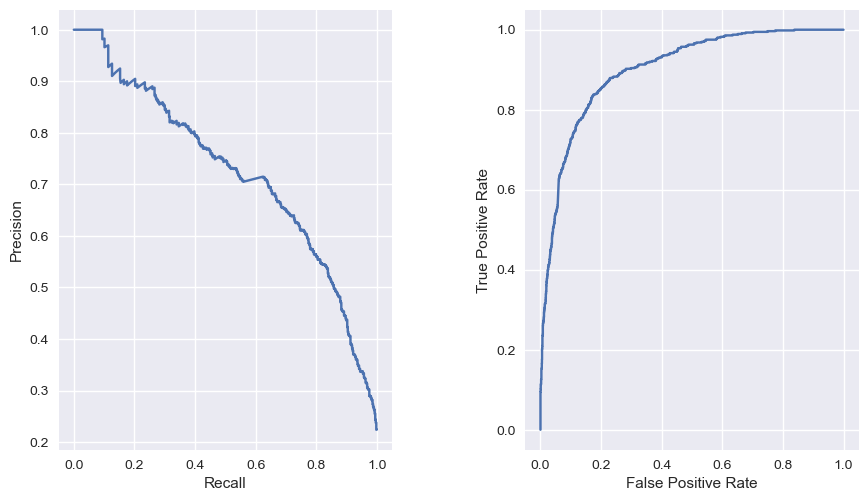

In [45]:
from sklearn.neural_network import MLPClassifier
mlp_train_accuracy, mlp_test_accuracy, mlp_train_auc, mlp_test_auc= check_scores(MLPClassifier(max_iter=500, random_state=42).fit(x_train, y_train), x_train,x_test,y_train,y_test)

# LSTM

In [46]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

((11541, 124), (11541,))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
121/121 [==============================] - 21s 154ms/step - loss: 0.4733 - accuracy: 0.8039 - val_loss: 0.3484 - val_accuracy: 0.8441
Epoch 2/10
121/121 [==============================] - 19s 160ms/step - loss: 0.2789 - accuracy: 0.8894 - val_loss: 0.2901 - val_accuracy: 0.8798
Epoch 3/10
121/121 [==============================] - 19s 160ms/step - loss: 0.1917 - accuracy: 0.9250 - val_loss: 0.3129 - val_accuracy: 0.8805
Epoch 4/10
121/121 [==============================] - 19s 160ms/step - loss: 0.1497 - accuracy: 0.9444 - val_loss: 0.3135 - val_accuracy: 0.8821
Epoch 5/10
121/121 [==============================] - 19s 161ms/step - loss: 0.1222 - accuracy: 0.9542 - val_loss: 0.3510 - val_accuracy: 0.8816
Epoch 6/10
121/121 [==============================] - 19s 159ms/step - loss: 0.1046 - accuracy: 0.9618 - val_loss: 0.3973 - val_accuracy: 0.8695
Epoch 7/10
121/121 [==============================] - 19s 155ms/step - loss: 0.0865 - accuracy: 0.9684 - val_loss: 0.4407 - val_ac

In [48]:
y_test_pred=np.argmax(model.predict(X_test),axis=1)
y_train_pred=np.argmax(model.predict(X_train),axis=1)

242/242 [==============================] - 6s 24ms/step


In [50]:
test_acc_lstm = accuracy_score(y_test,y_test_pred)
train_acc_lstm = accuracy_score(y_train,y_train_pred)
test_roc_lstm = roc_auc_score(y_test,y_test_pred)
train_roc_lstm = roc_auc_score(y_train,y_train_pred)data = [('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
 ('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('KNeighbors',knn_train_accuracy, knn_test_accuracy, knn_train_auc, knn_test_auc ),
 ('AdaBoost',a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc ),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('Decision Tree ',dt_train_accuracy, dt_test_accuracy, dt_train_auc, dt_test_auc),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc),
('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
('Neural Network',mlp_train_accuracy, mlp_test_accuracy, mlp_train_auc, mlp_test_auc),
('LSTM',train_acc_lstm, test_acc_lstm, train_roc_lstm, test_roc_lstm )]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

SyntaxError: invalid syntax (3506351325.py, line 4)